In [37]:
import uproot
import coffea
from coffea import hist
import numpy as np
import seutils
from math import pi

%matplotlib inline
import matplotlib.pyplot as plt

import utils
import networkx as nx
import imp

In [38]:
imp.reload(utils)

<module 'utils' from '/uscms_data/d3/klijnsma/hgcal/history/flatntup-interpretation/utils.py'>

In [39]:
hits, tracks, vertices = utils.get_ntup('hgcalhistoryntuple_numEvent10.root')
print(hits.keys())
print(tracks.keys())
print(vertices.keys())

dict_keys([b'simhit_detid', b'simhit_x', b'simhit_y', b'simhit_z', b'simhit_eta', b'simhit_phi', b'simhit_pt', b'simhit_zside', b'simhit_siThickness', b'simhit_radiusToSide', b'simhit_siThickIndex', b'simhit_layer', b'simhit_layerWithOffset', b'simhit_isHalfCell', b'simhit_isSilicon', b'simhit_inEE', b'simhit_inHsi', b'simhit_inHsc', b'simhit_energy', b'simhit_emFraction', b'simhit_time', b'simhit_trackId', b'simhit_depth'])
dict_keys([b'simtrack_x', b'simtrack_y', b'simtrack_z', b'simtrack_momentum', b'simtrack_trackId', b'simtrack_vertexIndex', b'simtrack_pdgid'])
dict_keys([b'simvertex_x', b'simvertex_y', b'simvertex_z', b'simvertex_t', b'simvertex_id', b'simvertex_parentTrackId', b'simvertex_processType', b'simvertex_noParent'])


In [87]:
# Event filter to get at least 1 >20 MeV electron
photon_energies = tracks[b'simtrack_momentum'].E[tracks[b'simtrack_pdgid'] == 22]
filter_energetic_photon = (photon_energies > 20.).count_nonzero() > 0

In [88]:
event_iterator = utils.get_flat_event_iterator(
    hits, tracks, vertices,
    filter = filter_energetic_photon
    )
event = next(event_iterator)
# event = next(event_iterator)

In [89]:
def pdgids_to_colors(pdgids, asdict=False):
    pdgids = np.abs(pdgids)
    '''Translates a np array of pdgids to a array of colors'''
    colors = np.array([ {'color': 'grey'} if asdict else 'grey' for i in range(pdgids.shape[0])], dtype=object)
    for key, value in {
        22 : 'red',
        13 : 'blue',
        11 : 'green'
        }.items():
        colors[pdgids == key] = {'color' : value} if asdict else value
    return colors

## Energy distributions

/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  from ipykernel import kernelapp as app


array([4.67206833e+04, 4.67206833e+04, 5.52103741e+01, ...,
       2.23824387e+00, 1.10481764e+00, 1.36662871e+00])

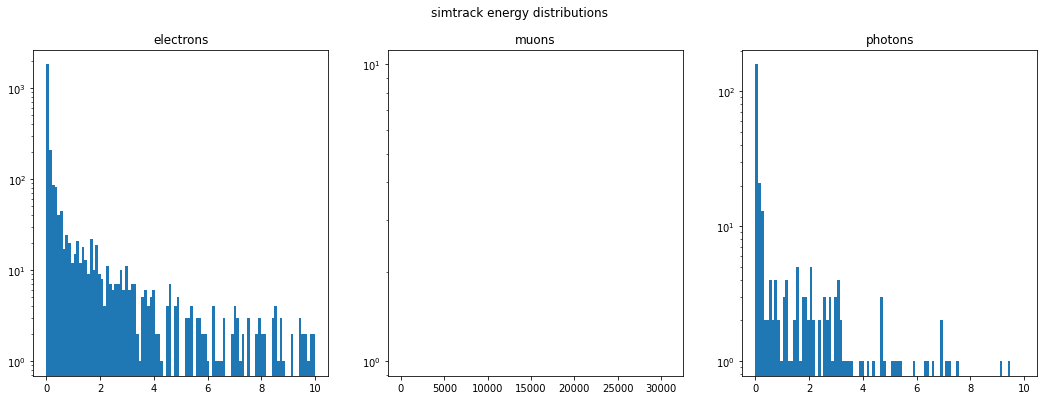

In [90]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

axs[0].hist(
    event.track_energy[np.abs(event.track_pdgid) == 11],
    bins = np.linspace(0.,10., 100),
    )
axs[0].set_title('electrons')
axs[0].set_yscale('log')

axs[1].hist(
    event.track_energy[np.abs(event.track_pdgid) == 13],
    bins = np.linspace(0.,31000., 100),
    )
axs[1].set_title('muons')
axs[1].set_yscale('log')

axs[2].hist(
    event.track_energy[np.abs(event.track_pdgid) == 22],
    bins = np.linspace(0.,10., 100),
    )
axs[2].set_title('photons')
axs[2].set_yscale('log')

fig.suptitle('simtrack energy distributions')

event.track_energy


# Tracks as nodes

In [91]:
G = nx.Graph()

# Tracks are nodes
def track_data(event):
    n = event.track_z.shape[0]    
    return np.array(
        [{
            'pdgid': event.track_pdgid[i],
            'energy' : event.track_energy[i]
            } for i in range(n)],
        dtype=object
        )
nodes = np.stack((event.track_trackId, track_data(event))).T
G.add_nodes_from(nodes)


track_has_parent = ~event.vertex_noParent[event.track_vertexIndex]
assert track_has_parent.shape == event.track_z.shape

edge_o = event.track_trackId[track_has_parent]
edge_i = event.vertex_parentTrackId[event.track_vertexIndex[track_has_parent]]
edges = np.stack((edge_i, edge_o)).T

G.add_edges_from(edges)

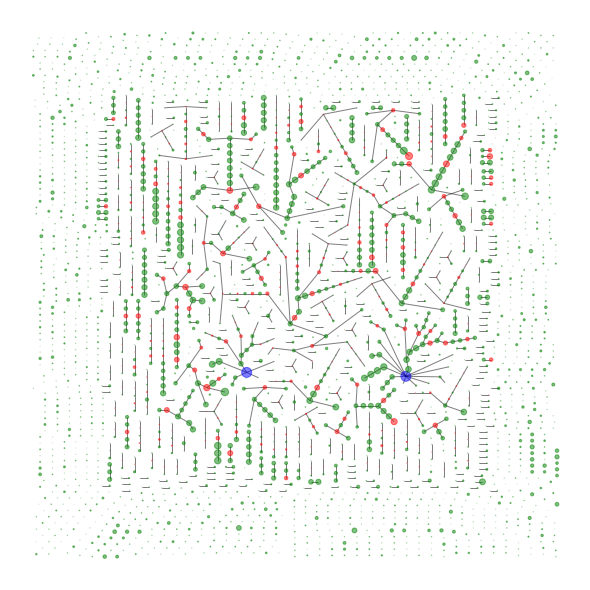

In [92]:
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout

def draw_graph(G):
    pos = graphviz_layout(G, prog='twopi', args='')
    plt.figure(figsize=(8, 8))
    energies = np.array([d['energy'] for n, d in G.nodes(data=True)])
    normed_energies = 100. * np.log(energies + 1.) / np.max(np.log(energies + 1.))
    nx.draw(
        G, pos,
        node_color = pdgids_to_colors(np.array([d['pdgid'] for n, d in G.nodes(data=True)])),
        node_size = normed_energies,
        alpha = 0.5,
        with_labels = False,
        )
    plt.axis('equal')
    plt.show()
    
draw_graph(G)

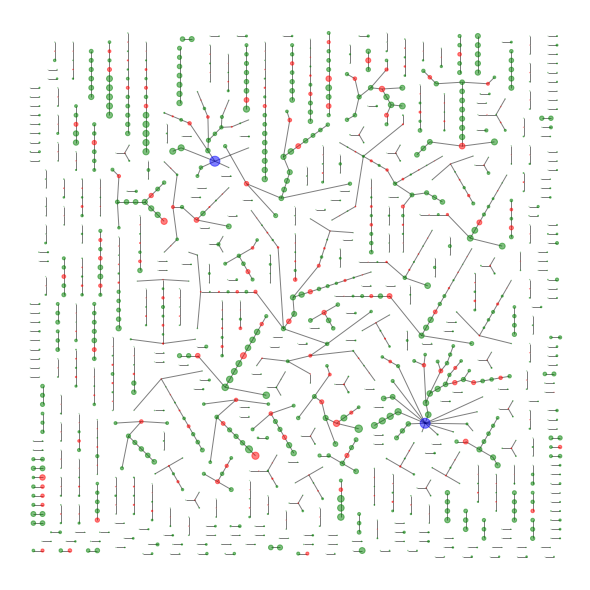

In [93]:
G.remove_nodes_from(list(nx.isolates(G)))
draw_graph(G)

# Tracks as edges

In [ ]:
G = nx.Graph()
G.add_nodes_from(event.vertex_id)

def get_vertex_edges(event):
    # Get all vertices that have a parent
    vertex_id = event.vertex_id[~event.vertex_noParent]
    # Get the parent track ids
    parent_track_id = event.vertex_parentTrackId[~event.vertex_noParent]
    # Get the indices of said parent track ids
    track_indices = utils.get_multiple_indices(parent_track_id, event.track_trackId)
    # Get the corresponding vertex id of the parent tracks
    parent_vertex_id = event.vertex_id[event.track_vertexIndex[track_indices]]
    # Should be the same length
    assert vertex_id.shape == parent_vertex_id.shape
    # Also get colors for the edges based on pdgid of the track connecting them
    pdgids = np.abs(event.track_pdgid[track_indices])
    colors = np.array([{'color': 'grey'} for i in range(pdgids.shape[0])], dtype=object)
    for key, value in {
        22 : 'red',
        13 : 'blue',
        11 : 'green'
        }.items():
        colors[pdgids == key] = {'color' : value}
    # Make edges
    # edges = np.stack((vertex_id, parent_vertex_id)).T
    edges = np.stack((vertex_id, parent_vertex_id, colors)).T
    # print(edges)
    return edges

G.add_edges_from(get_vertex_edges(event))